# SoS targets

* **Difficulty level**: easy
* **Time need to lean**: 10 minutes or less
* **Key points**:
  * Targets are objects that can be created and detected. They are passed to and from SoS steps as variables `_input`, `_output`, `step_input` and `step_ouptut`.
  * `file_target` represent disk files and are the most common targets used in SoS.  

Targets are objects that a SoS step can input, output, or dependent on. They are usually files that are presented by filenames, but can also be other targets.

## Target `file_target`

Targets of type `file_target` represents files on a file system. The type ``file_target` are usually not used explicitly because SoS treats string type targets as `file_target`. `file_target` 

* is derived from Python [pathlib.Path](https://docs.python.org/3/library/pathlib.html)
* automatically expands user from path starting with `~`
* allows you to extend `path` with a `+` operation
* has a special `zap` operation to replace (large) files with their signatures
* accepts a list of format options to easily format path in different formats

### Attributes and functions

`file_target` is derived from `pathlib.Path` but has a few additional features. It first automatically expands `~` if it is the first character of the path.

In [1]:
p = file_target('~/sos/sos-docs/src/user_guide/targets.ipynb')

In [2]:
p.name

'targets.ipynb'

In [3]:
p.parent

file_target('/Users/bpeng1/sos/sos-docs/src/user_guide')

In [4]:
p.parent / 'something.txt'

file_target('/Users/bpeng1/sos/sos-docs/src/user_guide/something.txt')

In [5]:
p.suffix

'.ipynb'

In [6]:
p.parts

('/',
 'Users',
 'bpeng1',
 'sos',
 'sos-docs',
 'src',
 'user_guide',
 'targets.ipynb')

In [7]:
p.exists()

True

In [8]:
p.is_dir()

False

In [9]:
p.with_name('sos_datatypes.html')

file_target('/Users/bpeng1/sos/sos-docs/src/user_guide/sos_datatypes.html')

In [10]:
p.with_suffix('.html')

file_target('/Users/bpeng1/sos/sos-docs/src/user_guide/targets.html')

and you can evaluate `file_target` in format strings as

In [11]:
f"Hello My name is {p.name}"

'Hello My name is targets.ipynb'

Note that `file_target` offers a [`os.PathLike`](https://docs.python.org/3/library/os.html#os.PathLike) interface and can be used directly with `os.path` functions such as

In [12]:
import os
os.path.getsize(p)

123983

The following is an example of using `with_suffix` on `_input`, which is of type `sos_targets` but in this case acts just like a `file_target`

In [13]:
!touch test1.bam test2.bam

input_files = ['test1.bam', 'test2.bam']
input: input_files, group_by=1
output: _input.with_suffix('.bai')

print(f"Generating {_output} from {_input}")
_output.touch()

Generating test1.bai from test1.bam
Generating test2.bai from test2.bam


### Operator `+` for `file_target`

`file_target` allows you to extend `file_target` with a `str` or `path` with a `+` operation. For example, with

In [14]:
p = file_target('test.txt')

`p + '.tmp'` returns a `path` with `.tmp` appended to the path

In [15]:
p + '.tmp'

file_target('test.txt.tmp')

which is different from the `/` operator that join the operant as another piece of the path

In [16]:
p / '.tmp'

file_target('test.txt/.tmp')

A note of caution, however, is that because `file_target` strips ending slash from an input path

In [17]:
file_target('/path/to/')

file_target('/path/to')

The result of the following can be surprising

In [18]:
file_target('/path/to/') + 'a.txt'

file_target('/path/toa.txt')

so the rule of thumb is that you should use `/` to extend path and `+` to extend name, as in

In [19]:
file_target('/path/to') / "dir" / "filename" + ".ext"

file_target('/path/to/dir/filename.ext')

Because `sos_targets` with a single `file_target` will act like a `file_target`, the following is an example of using `+` directly on `_input` to generate `_output` of a substep

In [20]:
!touch test1.bam test2.bam

input_files = ['test1.bam', 'test2.bam']
input: input_files, group_by=1
output: _input + '.bai'

print(f"Generating {_output} from {_input}")
_output.touch()

Generating test1.bam.bai from test1.bam
Generating test2.bam.bai from test2.bam


### Format specification

`file_target` accepts a list of format options to easily format path in different formats:


| convertor |operation| effect | operant | output |
| :----------|:----| :----- | :----- | :-------|
| `a`       | absolute path  | `abspath()` |  `test.sos` | `/path/to/test.sos` |
| `b`       | base filename  | `basename())` |  `{home}/SoS/test.sos` | `test.sos` |
| `e`       | escape  | `replace(' ', '\\ ')` | `file 1.txt` | `file\ 1.txt`|
| `d`       | directory name  | `dirname()` or `'.'` |  `/path/to/test.sos` | `/path/to` |
| `l`      | expand link   | `realpath()` | `test.sos` | `/realpath/to/test.sos` |
| `n`      | remove extension   | `splitext()[0]` | `/path/to/test.sos` | `/path/to/test` |
| `p`     | posix name    | `replace('\\', '/')...` | `c:\\Users` | `/c/Users` | 
| `q`     |quote    | `quoted()` | `file 1.txt` | `'file 1.txt'`|
| `r`     | repr | `repr()` | `file.txt` | `'file.txt'` |
| `s`    | str | `str()` | `file.txt` | `file.txt` |
| `R`   | resolve remote and other targets | `.resolve()`| `remote('a.txt')` | `a.txt`|
| `U`   | undo expanduser | `replace(expanduser('~'), '~')` | `/home/user/test.sos` | `~/test.sos` |
| `x`      | file extension   | `splitext()[1]` | `~/SoS/test.sos` | `.sos` |
| `,`   | join with comma      | `','.join()` | `['a.txt', 'b.txt']` | `a.txt,b.txt`|


These format options allow you to pass filenames to scripts in different formats. For example, it would be perfectly OK to pass `~/a.txt` to a shell script, but a `u` formatter should be added if you are passing the filename to a script that does not understand `~` in filenames. For example,

In [21]:
%preview -n name filename basefilename expanded parparname shortname
file = file_target('~/sos/examples/update_toc.sos')
name = f"{file:n}"
filename = f"{file:b}"
basefilename = f"{file:bn}"
expanded = f"{file:u}"
parparname = f"{file:ddb}"
shortname = f"{file:U}"

>>> name:

'/Users/bpeng1/sos/examples/update_toc'

>>> filename:

'update_toc.sos'

>>> basefilename:

'update_toc'

>>> expanded:

'/Users/bpeng1/sos/examples/update_toc.sos'

>>> parparname:

'sos'

>>> shortname:

'~/sos/examples/update_toc.sos'

The last example is pretty interesting because it applies three converters and gets the name of grand-parent directory using an equivalence of `basename(dirname(dirname(file)))`.

Note that, for completeness, we list the `R` formatter here although this formatter is used to resolve special targets, for example a `remote` target `remote(target)`, to a regular `BaseTarget`. For example,

In [22]:
a = sos_targets(remote('file.txt'), sos_variable('some'))

In [23]:
f"{a}"

'remote("file.txt") sos_variable("some")'

In [24]:
f"{a:R,}"

'file.txt,some'

Finally, `path` formats the object with these format operators and then the resulting string with additional formatters. For example, you can format the `path` object as a regular string

In [25]:
f"{file:>50}"

'         /Users/bpeng1/sos/examples/update_toc.sos'

or apply `path` formatter (`bn` for base name of filename) and then as a regular string.

In [26]:
f"{file:bn>50}"

'                                        update_toc'

The following example uses `:n` to get the basename of `_input` and add new suffix. It is in this case the same as `_input.with_suffix('.bam.bai')` so it is often a personal preference which style to use.

In [27]:
!touch test1.bam test2.bam

input_files = ['test1.bam', 'test2.bam']
input: input_files, group_by=1
output: f"{_input:n}.bam.bai"

print(f"Generating {_output} from {_input}")
_output.touch()

Generating test1.bam.bai from test1.bam
Generating test2.bam.bai from test2.bam


The third addition of the `path` type is **a `zap()` function that removes the file and creates a `{filename}.zapped` file with file signatures**. This `.zapped` file is considered to be "existent" by the runtime signature system so that a workflow step will not be repeated of some of its input or output files are zapped, unless the actually files are needed. This function is usually used as `sos_targets.zap()` to zap all input or output files, and will be demonstrated in detail in [SoS datatypes](sos_datatypes.html).

## Target `executable` 

`executable` targets are commands that should be accessible and executable by SoS. These targets are usually listed in the `depends` section of a SoS step. For example, SoS would stop if a command `fastqc` is not found.

In [28]:
%env --expect-error

%run
[10]
input:     'a.txt'
depends:   executable('some_command')
sh: expand=True
    some_command {input}

ERROR: No rule to generate target 'executable("some_command")', needed by '10'.


RuntimeError: Workflow exited with code 1

`executable` target can also be output of a step but installing executables can be tricky because the commands should be installed to existing `$PATH` so that they can be immediately accessible by SoS. Because SoS automatically adds `~/.sos/bin` to `$PATH` (option `-b`), an environment-neutral way for on-the-fly installation is to install commands to this directory. For example

You can also have finer control over which version of the command is eligible by checking the output of commands. The trick here is to provide a complete command and one or more version strings as the string that should appear in the output of the command.

For example, command `python --version` is executed in the following example to check if the output contains string `5.18`. The step would only be executed if the right version exists.

In [29]:
%run -v0
[10]
depends: executable('python --version', version='3.7.3')
print('ok')

[#] 1 step processed (1 job completed)


If no verion string is provided, SoS will only check the existence of the command and not actually execute the command.

## Target `sos_variable` 

`sos_variable(name)` targets represent SoS variables that are created by a SoS step and shared to other steps. These targets can be used to provide information to other steps. For example,

In [30]:
%run -v1

[counts: shared='counts']
input: 'result.txt'
with open(_input) as ifile:
    counts = int(ifile.read())

[10]
# perform some task and create a file with some statistics
output: 'result.txt'
run:
   echo 100 > result.txt 

[100]
depends: sos_variable('counts')
report: expand=True
    There are {counts} objects

There are 100 objects



Step `100` needed some information extracted from output of another step (step `10`). You can either parse the information in step `100` or use another step to provide the information. The latter is recommended because the information could be requested by multiple steps. Note that `counts` is an auxiliary step that provides `sos_variable('counts')` through its `shared` section option.

## Target `env_variable` 

SoS keeps tract of runtime environment and creates signatures of executed steps so that they do not have to be executed again. Some commands, especially shell scripts, could however behave differently with different environmental variables. To make sure a step would be re-executed with changing environments, you should list the variables that affects the output of these commands as dependencies of the step. For example

In [31]:
%env --expect-error

%run
[10]
depends:   env_variable('DEBUG')
sh:
    echo DEBUG is set to $DEBUG

ERROR: No rule to generate target 'env_variable("DEBUG")', needed by '10'.


RuntimeError: Workflow exited with code 1

## Target `sos_step` 

The `sos_step` target represents, needless to say, a SoS step. This target provides a straightforward method to specify step dependencies. For example,

In [32]:
%run -s force -v1
[init]
print("Initialize")

[10]
depends: sos_step("init")
print(f"I am {step_name}")

Initialize
I am 10


What is more interesting, however, is that `sos_step('a')` matches to steps such as `a_1`, `a_2` so the step will depend on the execution of the entire workflow.

For example, in the following workflow, step `default` depends on `sos_step('work')`, which triggers a process-oriented workflow `work` with steps `work_1` and `work_2`.

> test.dot (859 B):

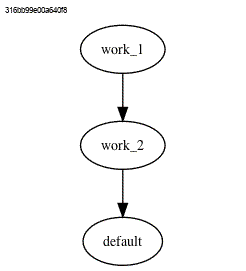

In [33]:
%preview -n test.dot
%run -v1 -d test.dot

[work_1]
# generate result
output: 'result.txt'
sh: expand=True
  echo some result > {_output}

[work_2]
# backup result
output: 'result.txt.bak'
sh: expand=True
  cp {_input} {_output}
  
[default]
depends: sos_step("work")

This example is similar to the following workflow that uses subworkflow (`sos_run('work')`) but as you can see from the generated DAG, the execution logics of the two are quite different. More specifically, the `sos_step()` target adds a subworkflow to the master DAG, while `sos_run` triggers a separate DAG. 

> test.dot (917 B):

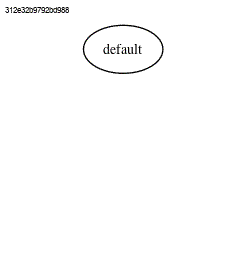

In [34]:
%preview -n test.dot
%run -v1 -d test.dot

[work_1]
# generate result
output: 'result.txt'
sh: expand=True
  echo some result > {_output}

[work_2]
# backup result
output: 'result.txt.bak'
sh: expand=True
  cp {_input} {_output}
  
[default]
sos_run("work")

### Target `dynamic` 

A `dynamic` target is a target that can only be determined when the step is actually executed. 

For example,

In [35]:
!rm -f *.bat

%run -v1

[10]
output: '*.bat'
sh:
    touch a.bat

[20]
print(f'Last output is {_input}')

Last output is 


To address this problem, you should try to expand the output file after the completion of the step, using a `dynamic` target.

In [36]:
!rm -f *.bat
%run -v1

[10]
output: dynamic('*.bat')
sh:
    touch a.bat

[20]
print(f"Last output is {_input}")

Last output is a.bat


Please refer to chapter [SoS Step](SoS_Step.html) for details of such targets.

### Target `remote`

A target that is marked as `remote` and would be instantiated only when it is executed by a task. Please check section [Remote Execution](Remote_Execution.html) for details.

### Target `system_resource`

Target `system_resource` checks the available system resource and is available only if the system has enough memory and/or diskspace for the workflow step. For example, the following step would generate an error if the system does not have at least `16G` of RAM and `1T` of disk space on the volume of the current project directory.

In [37]:
%env --expect-error

%run
[10]
depends: system_resource(mem='16G', disk='1T')
run:
   echo "some large job"

ERROR: No rule to generate target 'system_resource(mem='16G',disk='1T')', needed by '10'.


RuntimeError: Workflow exited with code 1

### Target `R_library`

The `R_library` target represents a R library. If the libraries are not available, it will try to install it from [CRAN](https://cran.r-project.org/), [bioconductor](https://www.bioconductor.org/), or [github](https://github.com/). Github package name should be formatted as `pkg@path`. A typical usage of this target would be

In [38]:
%run -v1
[10]
output: 'test.jpg'
depends: R_library('ggplot2')
R: expand=True
  library(ggplot2) 
  jpeg({_output:r})
  qplot(Sepal.Length, Petal.Length, data = iris, color = Species)
  dev.off()


null device 
          1 


`R_library` can also be used to check for specific versions of packages. For example:

```
R_library('edgeR', '3.12.0')
```
will result in a warning if edgeR version is not 3.12.0. You can specify multiple versions 

```
R_library('edgeR', ['3.12.0', '3.12.1'])
```

certain version or newer,
```
R_library('edgeR', '>=3.12.0')
```

certain version or older
```
check_R_library('ggplot2', '<1.0.0')
```

The default R library repo is `http://cran.us.r-project.org`. It is possible to customize the repo for which a R library would be installed, for example:

```
R_library('Rmosek', repos = "http://download.mosek.com/R/7")
```

To install from a github repository:

```
R_library('varbvs@pcarbo/varbvs/varbvs-R')
```
where `varbvs` is package name, `pcarbo/varbvs/varbvs-R` corresponds to sub-directory `varbvs-R` in repository `https://github.com/pcarbo/varbvs`.

### Target `Py_Module`

This target is usually used in the `depends` statement of a SoS step to specify a required Python module. For example,

In [39]:
%run

depends: Py_Module('tabulate')
from tabulate import tabulate
table = [["Sun",696000,1989100000],["Earth",6371,5973.6],
    ["Moon",1737,73.5],["Mars",3390,641.85]]
print(tabulate(table))

-----  ------  -------------
Sun    696000     1.9891e+09
Earth    6371  5973.6
Moon     1737    73.5
Mars     3390   641.85
-----  ------  -------------


If a module is not available, with `autoinstall=True` SoS will try to execute command `pip install` to install it, which might or might not succeed depending on your system configuration. For example,

```
Py_Module('numpy', autoinstall=True)
```

To specify version, 

```
Py_Module('numpy', version=">=1.14.0")
```

Or a shorthand syntax, 

```
Py_Module('numpy>1.14.0')
```

## Further reading

* [SoS datatypes](sos_datatypes.html)